In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %% minimal bootstrap
import sys, os, subprocess, importlib.util
from pathlib import Path

def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(50):
        if any((p / m).exists() for m in ("pyproject.toml", ".git", "defaults.yaml")):
            return p
        if p == p.parent: break
        p = p.parent
    return start.resolve()

_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    spec = importlib.util.find_spec(pkg_name)
    need = (not spec) or (not getattr(spec, "origin", None)) or (Path(spec.origin).resolve().parents[0] != pkg_dir.resolve())
    if need:
        print(f"Installing {pkg_name} in editable mode from {pkg_dir} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(pkg_dir)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

# %% imports & paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k
from diffinst.analysis_api import (
    load_manifest, load_config_from_run, list_checkpoints, load_metrics,
    load_linear_run, load_linear_Sigma_series, load_linear_amplitude,
    load_nonlinear_run, load_nonlinear_Sigma_series, load_nonlinear_amplitude,
    nearest_k_index, save_ic_npz, evp_gamma
)

EXP_DIFFSLOPE = ROOT / "experiments" / "diffinst.yaml"
EXP_DIFFSLOPE_NOISE = ROOT / "experiments" / "diffinst_noise.yaml" # has exact_fit = false
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

FIGURE_PATH = ROOT / "figures"; FIGURE_PATH.mkdir(exist_ok=True)

print("project root:", ROOT)



diffinst already installed from this repo.
project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


In [4]:
# Resolution Tests# %% global params & helpers for linear robustness tests

import subprocess
import sys


# Global knobs (you can tweak these)
K_MODE      = 100.0      # physical k for eigenmode ICs
#NX_IC       = 128        # grid size for ICs and TD runs
IC_AMP      = 1e-1       # small amplitude for linear regime
STOP_TIME   = 20.0       # total integration time (same for all runs, for now)
SAVE_STRIDE = 100        # how often to save checkpoints
PRINT_STRIDE = 400       # for nonlinear/dedalus logging


# Always the same yaml. Nx will be overwritten. still BRANCHES to define names though

BRANCHES = {
    "32": EXP_DIFFSLOPE,
    "64": EXP_DIFFSLOPE,
    "128": EXP_DIFFSLOPE,
    #"254": EXP_DIFFSLOPE,
}

NX = {
    "32": 32,
    "64": 64,
    "128": 128,
   # "254": 254,
}

DT_NONLIN = {
    "32":   1e-3,
    "64": 1e-3,
    "128": 1e-3,
    #"254": 1e-3,
}

DT_DEDALUS = {
    "32":  1e-3,
    "64": 1e-3,
    "128": 1e-3,
    #"254":1e-3,
}



# Base run directory for this notebook
RUN_BASE = ROOT / "runs" / "nonlinear_blowup"
RUN_BASE.mkdir(exist_ok=True)

IC_DIR = RUN_BASE / "ics"
IC_DIR.mkdir(exist_ok=True)

# Convenience: per-branch paths for IC and run directories
IC_PATHS = {
    name: IC_DIR / f"ic_{name}_k{int(K_MODE)}.npz"
    for name in BRANCHES.keys()
}

RUN_NL_NATIVE = {
    name: RUN_BASE / f"{name}_nl_native"
    for name in BRANCHES.keys()
}

RUN_DED_NL = {
    name: RUN_BASE / f"{name}_dedalus_nl"
    for name in BRANCHES.keys()
}


def run_cmd(cmd: list[str], *, allow_fail: bool = False, label: str | None = None):
    """Run a CLI command; optionally keep going on failure."""
    tag = f"[{label}] " if label is not None else ""
    print(tag + "Running:", " ".join(str(c) for c in cmd))
    result = subprocess.run(cmd, text=True, capture_output=True)

    if result.stdout:
        print(tag + result.stdout)
    if result.stderr:
        print(tag + result.stderr)

    if result.returncode != 0:
        msg = f"{tag}Command failed with code {result.returncode}"
        if allow_fail:
            print(msg)
        else:
            raise RuntimeError(msg)

In [4]:
# %% build eigenmode ICs for all branches (gas-inclusive configs)

for name, cfg_path in BRANCHES.items():
    ic_path = IC_PATHS[name]
    Nx = NX[name]
    cmd = [
        sys.executable, "-m", "scripts.make_ic_eigen",
        "--config", str(cfg_path),
        "--out", str(ic_path),
        "--k", str(K_MODE),
        "--amp", str(IC_AMP),
        "--Nx", str(Nx),
        "--exact-fit-harm", "2",
    ]
    run_cmd(cmd)

print("Eigenmode ICs written to:")
for name, ic_path in IC_PATHS.items():
    print(f"  {name}: {ic_path}")

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_32_k100.npz --k 100.0 --amp 0.1 --Nx 32 --exact-fit-harm 2
[make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_32_k100.npz (k=100.0, amp=0.1, Nx=32)

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_64_k100.npz --k 100.0 --amp 0.1 --Nx 64 --exact-fit-harm 2
[make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_64_k100.npz (k=100.0, amp=0.1

In [5]:
# %% run native nonlinear TD for all branches from eigenmode ICs

for name, cfg_path in BRANCHES.items():
    outdir = RUN_NL_NATIVE[name]
    outdir.mkdir(parents=True, exist_ok=True)
    Nx = NX[name]
    
    dt = DT_NONLIN[name]

    cmd = [
        sys.executable, "-m", "scripts.run_nonlinear",
        "--config", str(cfg_path),
        "--outdir", str(outdir),
        "--mode", "nonlinear",
        "--dt", str(dt),
        "--stop-time", str(STOP_TIME),
        "--save-stride", str(SAVE_STRIDE),
        "--init-from", str(IC_PATHS[name]),
        "--Nx", str(Nx),
        "--print-stride", "400",
        "--force",
    ]
    run_cmd(cmd)

print("Native nonlinear TD runs completed. Output dirs:")
for name, outdir in RUN_NL_NATIVE.items():
    print(f"  {name}: {outdir}")

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.run_nonlinear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/32_nl_native --mode nonlinear --dt 0.001 --stop-time 20.0 --save-stride 100 --init-from /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_32_k100.npz --Nx 32 --print-stride 400 --force
[INFO] Removing existing output directory: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/32_nl_native
[nonlinear] done: {'t_final': 20.0, 'steps': 20000, 'Nx': 32, 'Lx': 0.12566370614359174}

2025-12-09 22:06:06,975 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=400  t=4.000000e-01  dt=1.000e-03
2025-12-09 22:06:07,338 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=800  t=8.000000e-01  dt=1.000e-03
2025-12-09 2

In [6]:
# %% run DEDALUS nonlinear TD for all branches from eigenmode ICs

for name, cfg_path in BRANCHES.items():
    outdir = RUN_DED_NL[name]
    outdir.mkdir(parents=True, exist_ok=True)
    Nx = NX[name]
    dt = DT_DEDALUS[name]

    cmd = [
        sys.executable, "-m", "scripts.run_nonlinear",
        "--config", str(cfg_path),
        "--outdir", str(outdir),
        "--mode", "nonlinear",
        "--backend", "dedalus",
        "--dt", str(dt),
        "--stop-time", str(STOP_TIME),
        "--save-stride", str(SAVE_STRIDE),
        "--init-from", str(IC_PATHS[name]),
        "--Nx", str(Nx),
        "--print-stride", "400",
        "--force",
    ]

    # don't abort the whole sweep if one run blows up
    run_cmd(cmd, allow_fail=True, label=name)

print("Dedalus nonlinear TD runs attempted. Output dirs:")
for name, outdir in RUN_DED_NL.items():
    print(f"  {name}: {outdir}")

[32] Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.run_nonlinear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/32_dedalus_nl --mode nonlinear --backend dedalus --dt 0.001 --stop-time 20.0 --save-stride 100 --init-from /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_32_k100.npz --Nx 32 --print-stride 400 --force
[32] [INFO] Removing existing output directory: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/32_dedalus_nl
2025-12-09 22:07:04,159 subsystems 0/1 INFO :: Building subproblem matrices 1/16 (~6%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+01/s
2025-12-09 22:07:04,170 subsystems 0/1 INFO :: Building subproblem matrices 2/16 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s
2025-12-09 22:07:04,196 subsystems 0/1 INFO :: Buildi

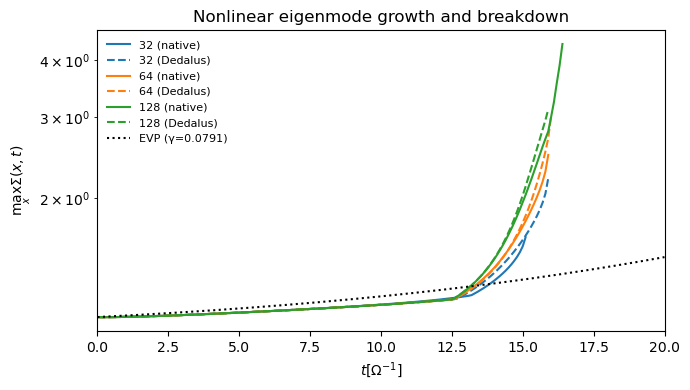

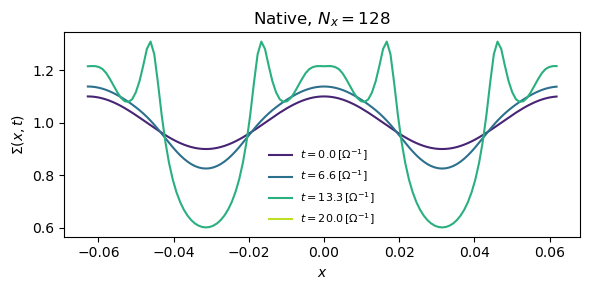

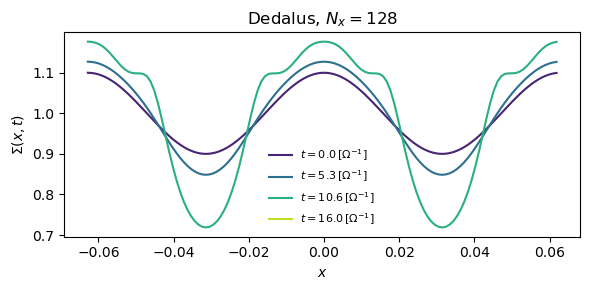

In [7]:
# %% wiring for nonlinear viz

from diffinst.vis.nonlinear import (
    plot_sigma_max_vs_time,
    plot_sigma_snapshots,
)


BRANCH_RUNS = {
    name: {
        "run_native": RUN_NL_NATIVE[name],
        "run_dedalus": RUN_DED_NL[name],   # may or may not exist
    }
    for name in BRANCHES.keys()
}

fig_max, ax_max = plot_sigma_max_vs_time(
    BRANCH_RUNS,
    k_phys=K_MODE,
    figsize=(7, 4),
)

plt.show()

# --- Figure 2: snapshots for the highest-resolution run (adjust label as needed)
hi_label = "128"   # or whatever your max-Nx key is

fig_snap_native, ax_snap_native = plot_sigma_snapshots(
    RUN_NL_NATIVE[hi_label],
    n_snap=4,
    t_min=0.0,
    t_max=STOP_TIME,
    title=fr"Native, $N_x={NX[hi_label]}$",
)
plt.show()

# If/when Dedalus runs exist:
if RUN_DED_NL[hi_label].exists():
    fig_snap_ded, ax_snap_ded = plot_sigma_snapshots(
        RUN_DED_NL[hi_label],
        n_snap=4,
        t_min=0.0,
        t_max=STOP_TIME,
        title=fr"Dedalus, $N_x={NX[hi_label]}$",
    )
    plt.show()

/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/vis/nonlinear.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  return fig, ax


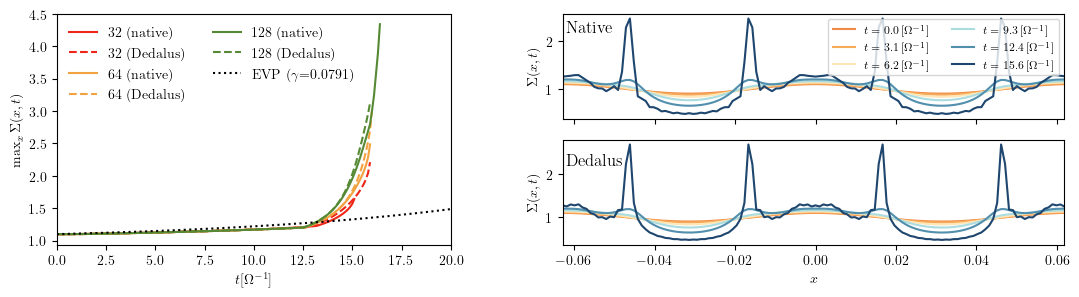

In [16]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

from diffinst.vis.nonlinear import plot_sigma_max_and_snapshots

branches = {
    "32":  {"run_native": RUN_NL_NATIVE["32"],  "run_dedalus": RUN_DED_NL["32"]},
    "64":  {"run_native": RUN_NL_NATIVE["64"],  "run_dedalus": RUN_DED_NL["64"]},
    "128": {"run_native": RUN_NL_NATIVE["128"], "run_dedalus": RUN_DED_NL["128"]},
}

fig, axes = plot_sigma_max_and_snapshots(
    branches,
    k_phys=K_MODE,
    snapshot_label="128",  # choose which Nx to show on the right
    n_snap=6,
    figsize=(13, 3)
)



fig.savefig(FIGURE_PATH / "nonlinear_blowup.pdf", bbox_inches="tight")

In [31]:
# %% noise-run parameters & paths (two resolutions)

NOISE_DT          = 1e-3
NOISE_STOP_TIME   = 10.0
NOISE_SAVE_STRIDE = 100
NOISE_PRINT_STRIDE = 300

NOISE_AMP   = 1e-2
NOISE_SEED  = 43

# two resolutions
NOISE_NX = {
    "lowres": 128,
    "midres" : 256, 
    "hires": 512,
}

RUN_NOISE_BASE = ROOT / "runs" / "noise_runs_twores"
RUN_NOISE_BASE.mkdir(parents=True, exist_ok=True)

RUN_NOISE_NATIVE = {
    label: RUN_NOISE_BASE / f"diffslope_noise_{label}"
    for label in NOISE_NX.keys()
}

# %% run native noise TD for both resolutions

for label, Nx_val in NOISE_NX.items():
    outdir = RUN_NOISE_NATIVE[label]
    outdir.mkdir(parents=True, exist_ok=True)

    cmd = [
        sys.executable, "-m", "scripts.run_nonlinear",
        "--config", str(EXP_DIFFSLOPE_NOISE),
        "--outdir", str(outdir),
        "--backend", "native",
        "--mode", "nonlinear",
        "--dt", str(NOISE_DT),
        "--stop-time", str(NOISE_STOP_TIME),
        "--save-stride", str(NOISE_SAVE_STRIDE),
        "--seed-mode", "noise",
        "--amp", str(NOISE_AMP),
        "--amp-physical",
        "--seed", str(NOISE_SEED),
        "--Nx", str(Nx_val),
        "--print-stride", str(NOISE_PRINT_STRIDE),
        "--force",
    ]
    run_cmd(cmd)

print("Native noise runs:")
for label, outdir in RUN_NOISE_NATIVE.items():
    print(f"  {label}: {outdir}")

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.run_nonlinear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst_noise.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/noise_runs_twores/diffslope_noise_lowres --backend native --mode nonlinear --dt 0.001 --stop-time 10.0 --save-stride 100 --seed-mode noise --amp 0.01 --amp-physical --seed 43 --Nx 128 --print-stride 300 --force
[INFO] Removing existing output directory: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/noise_runs_twores/diffslope_noise_lowres
[nonlinear] done: {'t_final': 10.0, 'steps': 10001, 'Nx': 128, 'Lx': 0.1}

2025-12-09 22:45:55,547 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=300  t=3.000000e-01  dt=1.000e-03
2025-12-09 22:45:55,839 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=600  t=6.000000e-01  dt=1.000e-03
2025-12-09 22:45:56,253 diffinst.solvers.native_

/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/vis/nonlinear.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  try:


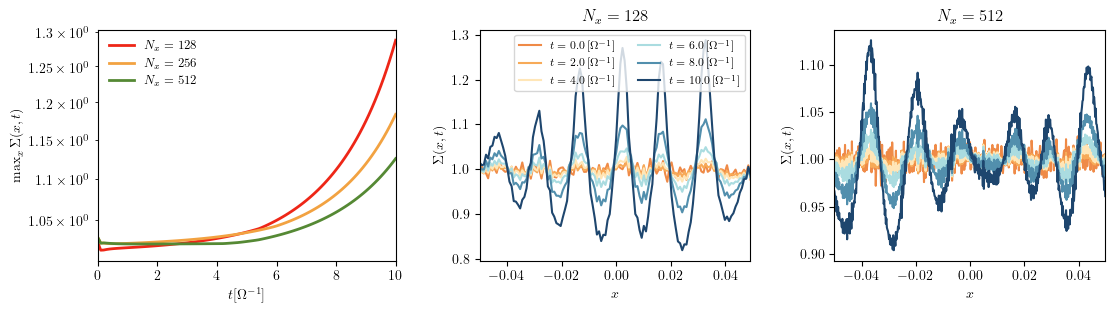

In [35]:
# %% visualize noise runs (two resolutions)

from diffinst.vis.nonlinear import plot_noise_two_res_summary

# pick keys matching NOISE_NX above
run_low_dir  = RUN_NOISE_NATIVE["lowres"]
run_mid_dir  = RUN_NOISE_NATIVE["midres"]
run_high_dir = RUN_NOISE_NATIVE["hires"]

fig, axes = plot_noise_two_res_summary(
    run_low=run_low_dir,
    run_mid=run_mid_dir,
    run_high=run_high_dir,
    label_low=r"$N_x=128$",
    label_mid=r"$N_x=256$",
    label_high=r"$N_x=512$",
    #k_ref=K_MODE,   # or some other reference k if you prefer
    k_ref=None,
    n_snap=6,
    figsize=(13,3)
)

plt.show()

fig.savefig(FIGURE_PATH / "noise_evolution.pdf", bbox_inches="tight")

/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/vis/nonlinear.py:811: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


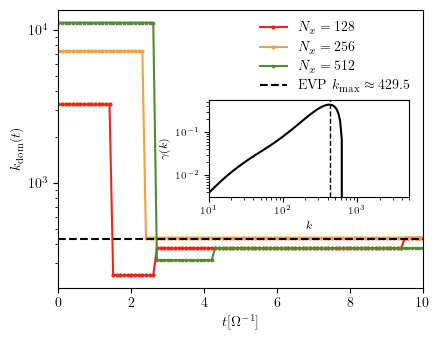

In [33]:
# %% dominant-mode vs theory plot for noise runs

import importlib
import diffinst.vis.nonlinear as nlviz
importlib.reload(nlviz)
from diffinst.vis.nonlinear import plot_noise_dominant_mode_vs_theory

run_low_dir  = RUN_NOISE_NATIVE["lowres"]
run_mid_dir  = RUN_NOISE_NATIVE["midres"]
run_high_dir = RUN_NOISE_NATIVE["hires"]

fig, axes = plot_noise_dominant_mode_vs_theory(
    run_low=run_low_dir,
    run_mid=run_mid_dir,
    run_high=run_high_dir,
    cfg_path=EXP_DIFFSLOPE_NOISE,   # or a dedicated noise config with same physics
    label_low=r"$N_x=128$",
    label_mid=r"$N_x=256$",
    label_high=r"$N_x=512$",
    kmin=10.0,
    kmax=5e3,
    nk=120,
    amp_floor=1e-6,
    figsize=(4.5,3.5)
)

plt.show()

fig.savefig(FIGURE_PATH / "noise_dominant_k.pdf", bbox_inches="tight")

### Avoiding nonlinear blowup

In [13]:

EXP_DIFFSLOPE_NOISE = ROOT / "experiments" / "diffinst_noise.yaml"

# %% piecewise vs power-law: noise runs

import sys
from pathlib import Path

# configs:
# - EXP_DIFFSLOPE_NOISE: original power-law diffusion (already defined)
# - EXP_DIFFINST_PW_NOISE: same, but with enable_piecewise_diffusion: true, sigma_sat_factor: 2.0
EXP_DIFFINST_PW_NOISE = ROOT / "experiments" / "diffinst_noise_piecewise.yaml"

# time-stepping + IC parameters (feel free to tweak)
PW_NOISE_DT           = 3e-4
PW_NOISE_STOP_TIME    = 40.0
PW_NOISE_SAVE_STRIDE  = 200
PW_NOISE_PRINT_STRIDE = 400

PW_NOISE_AMP   = 1e-2
PW_NOISE_SEED  = 43
PW_NOISE_NX    = 512   # single, well-resolved run for this comparison

RUN_PW_BASE = ROOT / "runs" / "noise_piecewise_test"
RUN_PW_BASE.mkdir(parents=True, exist_ok=True)

RUN_PW_POWERLAW = RUN_PW_BASE / "powerlaw_noise"
RUN_PW_PIECEWISE = RUN_PW_BASE / "piecewise_noise_sat2"

for cfg_path, outdir in [
    (EXP_DIFFSLOPE_NOISE, RUN_PW_POWERLAW),
    (EXP_DIFFINST_PW_NOISE, RUN_PW_PIECEWISE),
]:
    outdir.mkdir(parents=True, exist_ok=True)
    cmd = [
        sys.executable, "-m", "scripts.run_nonlinear",
        "--config", str(cfg_path),
        "--outdir", str(outdir),
        "--backend", "native",
        "--mode", "nonlinear",
        "--dt", str(PW_NOISE_DT),
        "--stop-time", str(PW_NOISE_STOP_TIME),
        "--save-stride", str(PW_NOISE_SAVE_STRIDE),
        "--seed-mode", "noise",
        "--amp", str(PW_NOISE_AMP),
        "--amp-physical",
        "--seed", str(PW_NOISE_SEED),
        "--Nx", str(PW_NOISE_NX),
        "--print-stride", str(PW_NOISE_PRINT_STRIDE),
        "--force",
    ]
    run_cmd(cmd, label=outdir.name)

print("Piecewise vs power-law noise runs:")
print("  power law :", RUN_PW_POWERLAW)
print("  piecewise:", RUN_PW_PIECEWISE)

[powerlaw_noise] Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.run_nonlinear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst_noise.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/noise_piecewise_test/powerlaw_noise --backend native --mode nonlinear --dt 0.0003 --stop-time 40.0 --save-stride 200 --seed-mode noise --amp 0.01 --amp-physical --seed 43 --Nx 512 --print-stride 400 --force
[powerlaw_noise] [INFO] Removing existing output directory: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/noise_piecewise_test/powerlaw_noise
[nonlinear] done: {'t_final': 40.0, 'steps': 133334, 'Nx': 512, 'Lx': 0.1}

[powerlaw_noise] 2025-12-11 16:17:02,242 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=400  t=1.200000e-01  dt=3.000e-04
2025-12-11 16:17:02,785 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=800  t=2.400000e-01  dt=3.000e-04
2025-

<string>:31: RuntimeWarning: All-NaN slice encountered
<string>:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


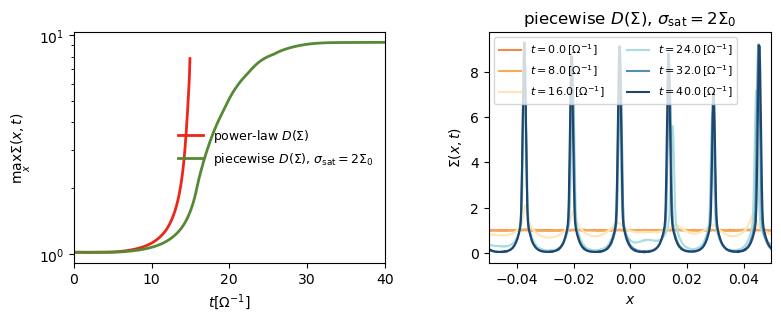

In [14]:
# %% visualize saturation vs blow-up for piecewise diffusion (2-panel)

from diffinst.vis.nonlinear import plot_piecewise_noise_comparison

run_powerlaw  = RUN_PW_POWERLAW
run_piecewise = RUN_PW_PIECEWISE

fig, axes = plot_piecewise_noise_comparison(
    run_powerlaw=run_powerlaw,
    run_piecewise=run_piecewise,
    label_powerlaw=r"power-law $D(\Sigma)$",
    label_piecewise=r"piecewise $D(\Sigma)$, $\sigma_{\rm sat}=2\Sigma_0$",
    n_snap=6,
    figsize=(9.0, 3.0),
)

plt.show()

fig.savefig(FIGURE_PATH / "noise_piecewise_vs_powerlaw.pdf",
            bbox_inches="tight")

[IC_neutvisc_32] Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst_neutralviscslope.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_neutralvisc/ics/ic_neutvisc_32_k100.npz --k 100.0 --amp 0.1 --Nx 32 --exact-fit-harm 2
[IC_neutvisc_32] [make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_neutralvisc/ics/ic_neutvisc_32_k100.npz (k=100.0, amp=0.1, Nx=32)

[IC_neutvisc_64] Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst_neutralviscslope.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_neutralvisc/ics/ic_neutvisc_64_k100.npz --k 100.0 --amp 0.1 --Nx 64 --exact-fit-harm 2
[IC_neutvisc_64] [make_ic_eig

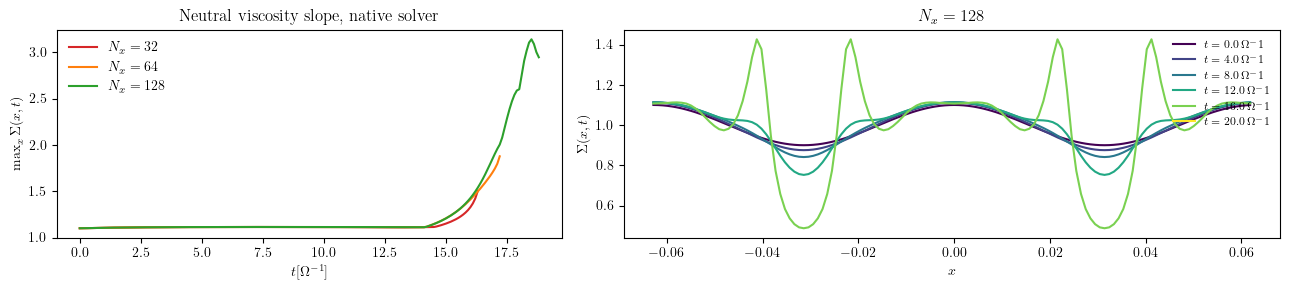

In [34]:
# test 1: neutral viscosity slope

EXP_DIFFINST_NEUTVISCSLOPE = ROOT / "experiments" / "diffinst_neutralviscslope.yaml"

# %% Neutral viscosity-slope experiment (native only)

# === setup runs & ICs ===

# use same K_MODE, IC_AMP, STOP_TIME, DT_NONLIN, NX as defined above
RUN_BASE_NEUT = ROOT / "runs" / "nonlinear_neutralvisc"
RUN_BASE_NEUT.mkdir(parents=True, exist_ok=True)

IC_DIR_NEUT = RUN_BASE_NEUT / "ics"
IC_DIR_NEUT.mkdir(parents=True, exist_ok=True)

# choose which resolutions to test (can reuse the global NX dict)
BRANCHES_NEUT = {
    "32":  EXP_DIFFINST_NEUTVISCSLOPE,
    "64":  EXP_DIFFINST_NEUTVISCSLOPE,
    "128": EXP_DIFFINST_NEUTVISCSLOPE,
}

NX_NEUT = {
    "32":  32,
    "64":  64,
    "128": 128,
}

DT_NONLIN_NEUT = {
    "32":  DT_NONLIN["32"],
    "64":  DT_NONLIN["64"],
    "128": DT_NONLIN["128"],
}

IC_PATHS_NEUT = {
    name: IC_DIR_NEUT / f"ic_neutvisc_{name}_k{int(K_MODE)}.npz"
    for name in BRANCHES_NEUT.keys()
}

RUN_NL_NATIVE_NEUT = {
    name: RUN_BASE_NEUT / f"{name}_nl_native_neutvisc"
    for name in BRANCHES_NEUT.keys()
}

# --- build eigenmode ICs for neutral-viscosity runs ---
for name, cfg_path in BRANCHES_NEUT.items():
    ic_path = IC_PATHS_NEUT[name]
    Nx_loc = NX_NEUT[name]

    cmd = [
        sys.executable, "-m", "scripts.make_ic_eigen",
        "--config", str(cfg_path),
        "--out", str(ic_path),
        "--k", str(K_MODE),
        "--amp", str(IC_AMP),
        "--Nx", str(Nx_loc),
        "--exact-fit-harm", "2",
    ]
    run_cmd(cmd, label=f"IC_neutvisc_{name}")

print("Neutral-viscosity eigenmode ICs written to:")
for name, ic_path in IC_PATHS_NEUT.items():
    print(f"  {name}: {ic_path}")

# --- run native nonlinear TD for all neutral-viscosity branches ---

for name, cfg_path in BRANCHES_NEUT.items():
    outdir = RUN_NL_NATIVE_NEUT[name]
    outdir.mkdir(parents=True, exist_ok=True)
    Nx_loc = NX_NEUT[name]
    dt = DT_NONLIN_NEUT[name]

    cmd = [
        sys.executable, "-m", "scripts.run_nonlinear",
        "--config", str(cfg_path),
        "--outdir", str(outdir),
        "--mode", "nonlinear",
        "--dt", str(dt),
        "--stop-time", str(STOP_TIME),
        "--save-stride", str(SAVE_STRIDE),
        "--init-from", str(IC_PATHS_NEUT[name]),
        "--Nx", str(Nx_loc),
        "--print-stride", str(PRINT_STRIDE),
        "--force",
    ]
    run_cmd(cmd, label=f"NL_native_neutvisc_{name}")

print("Neutral-viscosity native nonlinear runs completed.")
for name, outdir in RUN_NL_NATIVE_NEUT.items():
    print(f"  {name}: {outdir}")


# === plotting: max Σ vs t and snapshots (native only) ===
import glob

def load_sigma_max_series(run_dir: Path):
    """Return times and max_x Sigma(t) from checkpoint files in run_dir."""
    chk_dir = run_dir / "checkpoints"
    files = sorted(chk_dir.glob("chk_*.npz"))
    times = []
    sig_max = []
    for fn in files:
        data = np.load(fn)
        times.append(float(data["t"]))
        Sigma = data["Sigma"]
        sig_max.append(float(np.max(Sigma)))
    return np.array(times), np.array(sig_max)

def load_snapshots(run_dir: Path, n_snap=5):
    """Return x and list of Sigma(x,t) snapshots spaced through the run."""
    chk_dir = run_dir / "checkpoints"
    files = sorted(chk_dir.glob("chk_*.npz"))
    if len(files) == 0:
        raise RuntimeError(f"No checkpoints found in {chk_dir}")
    # choose approximately evenly spaced indices (including first & last)
    idx = np.linspace(0, len(files)-1, n_snap, dtype=int)
    snapshots = []
    ts = []
    x = None
    for i in idx:
        data = np.load(files[i])
        if x is None:
            x = data["x"]
        snapshots.append(data["Sigma"])
        ts.append(float(data["t"]))
    return x, snapshots, ts

# choose which Nx to show on the right (e.g. highest resolution)
SNAP_BRANCH = "128"

fig = plt.figure(figsize=(13, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 1.3])
ax_left = fig.add_subplot(gs[0, 0])
ax_right = fig.add_subplot(gs[0, 1])

# left: max Σ vs t for each resolution
colors = {
    "32":  "tab:red",
    "64":  "tab:orange",
    "128": "tab:green",
}
for name in BRANCHES_NEUT.keys():
    t, smax = load_sigma_max_series(RUN_NL_NATIVE_NEUT[name])
    ax_left.plot(t, smax, label=rf"$N_x = {NX_NEUT[name]}$", color=colors.get(name, None))

ax_left.set_xlabel(r"$t[\Omega^{-1}]$")
ax_left.set_ylabel(r"$\max_x \Sigma(x,t)$")
ax_left.legend(loc="upper left", frameon=False)
ax_left.set_title(r"Neutral viscosity slope, native solver")

# right: snapshots for chosen branch
x, sig_list, ts = load_snapshots(RUN_NL_NATIVE_NEUT[SNAP_BRANCH], n_snap=6)

cmap = plt.get_cmap("viridis")
for i, (Sigma, t_snap) in enumerate(zip(sig_list, ts)):
    ax_right.plot(x, Sigma,
                  color=cmap(i / max(len(sig_list)-1, 1)),
                  label=rf"$t = {t_snap:.1f}\,\Omega^{-1}$")
ax_right.set_xlabel(r"$x$")
ax_right.set_ylabel(r"$\Sigma(x,t)$")
ax_right.set_title(rf"$N_x = {NX_NEUT[SNAP_BRANCH]}$")
ax_right.legend(loc="upper right", frameon=False, fontsize=8)

fig.tight_layout()
fig.savefig(FIGURE_PATH / "nonlinear_neutralvisc.pdf", bbox_inches="tight")
plt.show()